In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import csv
from matplotlib.font_manager import FontProperties
from scipy.optimize import curve_fit

In [27]:
header_rows = 0
transmission_uc_data = pd.read_csv('data/2025.1.7couple/Uc m_arcf5.0_setv66.223_actw1549.4961.csv_.csv', skiprows=header_rows, nrows=None)
transmission_cc_data = pd.read_csv('data/2025.1.7couple/Cc_arcf4.0_setv66.223_actw1549.4961.csv_.csv', skiprows=header_rows, nrows=None)
transmission_oc_data = pd.read_csv('data/2025.1.7couple/Oc_arcf4.0_setv66.223_actw1549.4961.csv_.csv', skiprows=header_rows, nrows=None)
transmission_ooc_data = pd.read_csv('data/2025.1.7couple/Oc T_arcf4.0_setv66.223_actw1549.4961.csv_.csv', skiprows=header_rows, nrows=None) 

In [32]:
power_uc = transmission_uc_data['Power']
power_cc = transmission_cc_data['Power']
power_oc = transmission_oc_data['Power']
power_ooc = transmission_ooc_data['Power']
time_uc = transmission_uc_data['Time']
wl_uc = transmission_uc_data['Wavelength']
wl_cc = transmission_cc_data['Wavelength']
wl_oc = transmission_oc_data['Wavelength']
wl_ooc = transmission_ooc_data['Wavelength']
fq_uc = 299792458 / wl_uc * 1e3
fq_cc = 299792458 / wl_cc * 1e3
fq_oc = 299792458 / wl_oc * 1e3
fq_ooc = 299792458 / wl_ooc * 1e3

# # 平滑处理，并去掉前后300个数据
rollingwindow = 80
power_uc = power_uc.rolling(rollingwindow).mean()
power_cc = power_cc.rolling(rollingwindow).mean()
power_oc = power_oc.rolling(rollingwindow).mean()
power_ooc = power_ooc.rolling(rollingwindow).mean()

# 以power_uc最低值的时间为基准，将时间轴平移
time_uc = time_uc - time_uc[power_uc.idxmin()]

# 以power最低值的时间为基准，将频率轴平移
fq_uc = fq_uc - fq_uc[power_uc.idxmin()]
fq_cc = fq_cc - fq_cc[power_cc.idxmin()]
fq_oc = fq_oc - fq_oc[power_oc.idxmin()]
fq_ooc = fq_ooc - fq_ooc[power_ooc.idxmin()]

# 以power前300个数据的平均值为基准，将功率轴归一化
power_uc = power_uc / power_uc[:3000].mean()
power_cc = power_cc / power_cc[:3000].mean()
power_oc = power_oc / power_oc[:3000].mean()
power_ooc = power_ooc / power_ooc[:3000].mean()


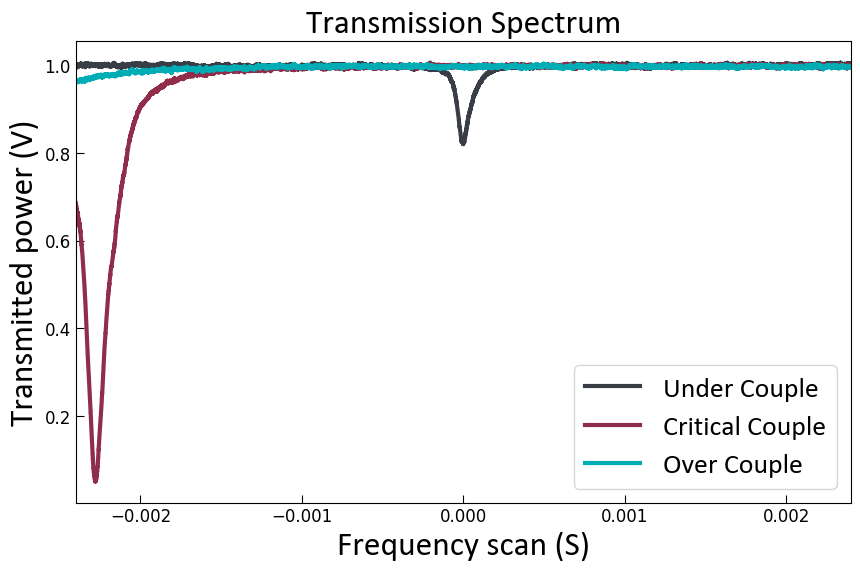

In [29]:
# 绘制光谱图
plt.figure(figsize=(10, 6))
# 绘制曲线
plt.plot(time_uc, power_uc, color='#393e46ff', linestyle='-', lw=3, label='Under Couple')
plt.plot(time_uc+0.000, power_cc, color='#902d4aff', linestyle='-', lw=3, label='Critical Couple')
plt.plot(time_uc+0.000, power_oc, color='#00adb5ff', linestyle='-', lw=3, label='Over Couple')
# 设置坐标轴范围、标签、标题、图例、网格等
plt.xlim(-0.0024, 0.0024) # 设置x轴范围 窄透射谱
# plt.xlim(-0.001, 0.005) # 设置x轴范围 宽透射谱
# plt.ylim(-70, 0) # 设置y轴范围

# 设置字体和字体大小
title_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 24}
label_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 24}
tick_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 20}
# 设置图例字体
legend_font = FontProperties(family='calibri', weight='normal', size=20)
# 设置刻度字体
plt.tick_params(axis='both', labelsize=12)  # 刻度字体大小

# 设置刻度线向内
plt.tick_params(axis='both', direction='in', length=6)  # 轴 'both' 表示x轴和y轴都应用此设置，direction='in' 表示刻度线向内，length=6 设置刻度线长度

plt.xlabel('Frequency scan (S)', fontdict=label_font)
plt.ylabel('Transmitted power (V)', fontdict=label_font)
plt.title('Transmission Spectrum', fontdict=title_font)
plt.legend(prop=legend_font)
# plt.grid(True)
# 导出为矢量图格式（SVG 或 PDF），确保高质量
plt.savefig('data/2025.1.7couple/透射谱窄.svg', format='svg', dpi=300)  # 可选择 'pdf' 或 'svg' 等格式
plt.show()

In [33]:
""" Fit the data """
# x = time_values
x = fq_uc[rollingwindow:-rollingwindow]
y = power_uc[rollingwindow:-rollingwindow]
# Define the math function want to fit
def Lorentz(x,y0,A,xc,w):
    y = y0 + (2*A/np.pi)*(w/(4*(x-xc)**2 + w**2))
    return y

# Define the initial values
y0 = 1
A = -1.5
# xc = 193446417.30750528
xc = 0
w = 5

popt, pcov = curve_fit(Lorentz, x, y, p0=[y0,A,xc,w], maxfev=100000)
x_fit = np.linspace(x.min(), x.max(), 100000)
y_fit = Lorentz(x_fit, *popt)

# extract the values of a, b, and c from the optimized parameters
y0, A, xc, w = popt

# extract the variances of a, b, and c from the covariance matrix
var_y0, var_A, var_xc, var_w = np.diag(pcov)

# print the results
print(f"y0 = {y0:.8f} +/- {np.sqrt(var_y0):.8f}")
print(f"A = {A:.8f} +/- {np.sqrt(var_A):.8f}")
print(f"xc = {xc:.8f} +/- {np.sqrt(var_xc):.8f}")
print(f"w = {w:.8f} +/- {np.sqrt(var_w):.8f}")


y0 = 0.99792122 +/- 0.00000302
A = -1.49015749 +/- 0.00098700
xc = 0.23187687 +/- 0.00178286
w = 5.41298314 +/- 0.00505641


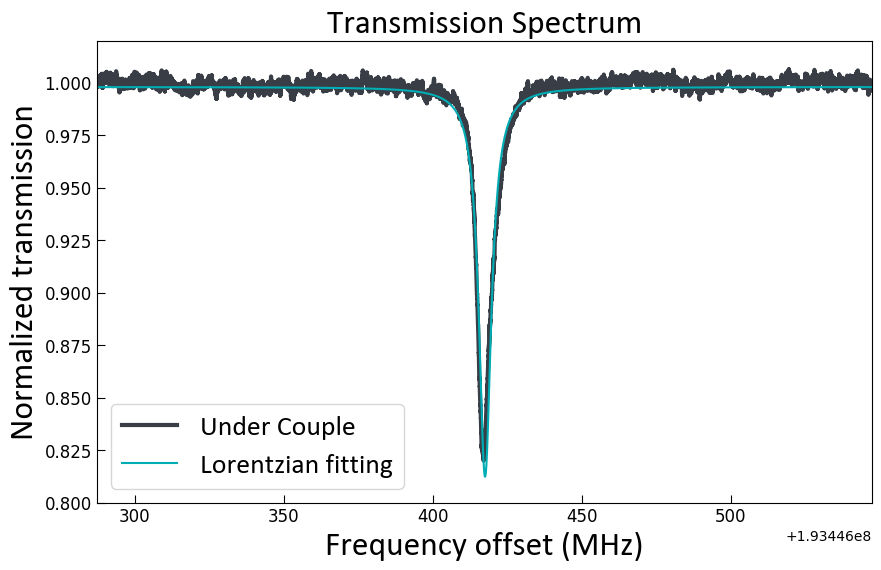

In [31]:
# 绘制光谱图
plt.figure(figsize=(10, 6))
# 绘制曲线
plt.plot(fq_uc, power_uc, color='#393e46ff', linestyle='-', lw=3, label='Under Couple')
# plt.plot(fq_cc, power_cc, color='#902d4aff', linestyle='-', lw=3, label='Critical Couple')
# plt.plot(fq_oc, power_oc, color='#00adb5ff', linestyle='-', lw=3, label='Over Couple')
# plt.plot(fq_ooc, power_ooc, color='#f38181ff', linestyle='-', lw=3, label='Over Over Couple')

plt.plot(x_fit, y_fit, color='#00adb5ff', linestyle='-', lw=1.5, label='Lorentzian fitting')

# 设置坐标轴范围、标签、标题、图例、网格等
plt.xlim(193446287.30750528, 193446547.30750528) # 设置x轴范围 窄透射谱
# plt.xlim(-0.001, 0.005) # 设置x轴范围 宽透射谱
plt.ylim(0.8, 1.02) # 设置y轴范围

# 设置字体和字体大小
title_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 24}
label_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 24}
tick_font = {'family': 'calibri', 'color':  'black', 'weight': 'normal', 'size': 20}
# 设置图例字体
legend_font = FontProperties(family='calibri', weight='normal', size=20)
# 设置刻度字体
plt.tick_params(axis='both', labelsize=12)  # 刻度字体大小

# 设置刻度线向内
plt.tick_params(axis='both', direction='in', length=6)  # 轴 'both' 表示x轴和y轴都应用此设置，direction='in' 表示刻度线向内，length=6 设置刻度线长度

plt.xlabel('Frequency offset (MHz)', fontdict=label_font)
plt.ylabel('Normalized transmission', fontdict=label_font)
plt.title('Transmission Spectrum', fontdict=title_font)
plt.legend(prop=legend_font)
# plt.grid(True)
# 导出为矢量图格式（SVG 或 PDF），确保高质量
plt.savefig('data/2025.1.7couple/透射谱窄频率.svg', format='svg', dpi=500)  # 可选择 'pdf' 或 'svg' 等格式
plt.show()